<a href="https://colab.research.google.com/github/graphtrek/stockforecast/blob/main/graphtrek_09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MAE
from tensorflow.keras.layers import Dense, Dropout
from tensorflow import keras
from datetime import datetime, timedelta
import pandas as pd
import os, time
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MAE
from tensorflow.keras.layers import Dense, Dropout
from tensorflow import keras
from datetime import datetime, timedelta
import pandas as pd
import os, time
from plotly.subplots import make_subplots
from pathlib import Path

In [37]:
ticker = 'ARKG' # QQQ, SPY, VTI JETS, XLE, XLF, XLNX, ARKK, ARKG, ARKQ, ARKF, PYPL, V
look_back = 3 #  number of past days we want to use to predict 1 day in the future.
max_data_size = 730 # ~2 years
split_percent = 0.90 # use 90% of the data  for train
INFO = 1
DEBUG = 2
TRACE = 3
print_level = DEBUG 
indicators_model_file_path = '/content/drive/MyDrive/models/' + ticker + '_' + str(look_back) + '_' + str(nr_of_features) + '_indicators_09.h5'
nr_of_features = 4
look_forward = 1
epochs = 420
learning_rate=0.0042
if look_back < 5:
  num_prediction = look_back * 4
else:
  num_prediction = look_back * 2

apikey = '3F4URDEKOPLFH25T'
np.random.seed(42)

In [38]:
rsi_url = 'https://www.alphavantage.co/query?function=RSI&datatype=json&symbol='+ticker+'&interval=daily&time_period='+str(look_back)+'&series_type=close&apikey=' + apikey
print(rsi_url)
rsi_api_response = pd.read_json(rsi_url)
#print(rsi_api_response)
rsi_api_data = rsi_api_response['Technical Analysis: RSI']
#print(rsi_api_data)
rsi_api_data = rsi_api_data.drop(
    index=['1: Symbol','2: Indicator','3: Last Refreshed','4: Interval','5: Time Period','6: Series Type','7: Time Zone']);
#print(rsi_api_data)

rsi_data = []
for key, value in rsi_api_data.items():
  date = key
  rsi = float(value.get('RSI'))
  rsi_data.append([date,rsi])

last_rsi_data =  str(rsi_data[0])
first_rsi_data =  str(rsi_data[-1])
print('rsi_data_length:', len(rsi_data), 'first_rsi_data:', first_rsi_data, 'last_rsi_data:', last_rsi_data)  

https://www.alphavantage.co/query?function=RSI&datatype=json&symbol=ARKG&interval=daily&time_period=3&series_type=close&apikey=3F4URDEKOPLFH25T
rsi_data_length: 1778 first_rsi_data: ['2014-11-05', 0.0] last_rsi_data: ['2021-11-26', 21.8192]


In [39]:
stoch_url = 'https://www.alphavantage.co/query?function=STOCH&symbol='+ticker+'&interval=daily&apikey=' + apikey
print(stoch_url)
stoch_api_response = pd.read_json(stoch_url)
stoch_api_data = stoch_api_response['Technical Analysis: STOCH']
#print(rsi_api_data)
stoch_api_data = stoch_api_data.drop(
    index=['1: Symbol','2: Indicator','3: Last Refreshed','4: Interval','5.1: FastK Period','5.2: SlowK Period','5.3: SlowK MA Type','5.4: SlowD Period','5.5: SlowD MA Type','6: Time Zone'])
#print(stoch_api_data)
stoch_data = []
for key, value in stoch_api_data.items():
  date = key
  SlowD = float(value.get('SlowD'))
  SlowK = float(value.get('SlowK'))
  stoch_data.append([date,SlowD,SlowK])

last_stoch_data =  str(stoch_data[0])
first_stoch_data =  str(stoch_data[-1])
print('stoch_data_length:', len(stoch_data), 'first_stoch_data:', first_stoch_data, 'last_stoch_data:', last_stoch_data)  

https://www.alphavantage.co/query?function=STOCH&symbol=ARKG&interval=daily&apikey=3F4URDEKOPLFH25T
stoch_data_length: 1773 first_stoch_data: ['2014-11-12', 31.3289, 42.105] last_stoch_data: ['2021-11-26', 14.6081, 23.5943]


In [40]:
macd_url = 'https://www.alphavantage.co/query?function=MACD&symbol='+ticker+'&interval=daily&series_type=open&apikey=' + apikey
print(macd_url)
macd_api_response = pd.read_json(macd_url)
macd_api_data = macd_api_response['Technical Analysis: MACD']
#print(macd_api_data)
macd_api_data = macd_api_data.drop(
    index=[
          '1: Symbol',
          '2: Indicator',
          '3: Last Refreshed',
          '4: Interval',
          '5.1: Fast Period',
          '5.2: Slow Period',
          '5.3: Signal Period',
          '6: Series Type',
          '7: Time Zone'
]);

macd_data = []
for key, value in macd_api_data.items():
  date = key
  MACD = float(value.get('MACD'))
  MACD_Hist = float(value.get('MACD_Hist'))
  MACD_Signal = float(value.get('MACD_Signal'))
  macd_data.append([date,MACD,MACD_Hist,MACD_Signal])

last_macd_data =  str(macd_data[0])
first_macd_data =  str(macd_data[-1])
print('macd_data_length:', len(macd_data), 'first_macd_data:', first_macd_data, 'last_macd_data:', last_macd_data) 

https://www.alphavantage.co/query?function=MACD&symbol=ARKG&interval=daily&series_type=open&apikey=3F4URDEKOPLFH25T
macd_data_length: 1748 first_macd_data: ['2014-12-18', 0.1243, -0.0278, 0.1521] last_macd_data: ['2021-11-26', -2.8641, -1.1694, -1.6947]


In [41]:
stock_url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol='+ticker+'&outputsize=full&apikey=' + apikey
print(stock_url)
stock_api_response = pd.read_json(stock_url)
stock_api_data = stock_api_response['Time Series (Daily)']
#print(stock_api_data)
stock_api_data = stock_api_data.drop(index=['1. Information','2. Symbol','3. Last Refreshed','4. Output Size','5. Time Zone']);

stock_data = []
split_coefficient = 1

for key, value in stock_api_data.items():
  date = key
  open = float(value.get('1. open'))
  high = float(value.get('2. high'))
  low = float(value.get('3. low'))
  close = float(value.get('4. close'))
  adjusted_close = float(value.get('5. adjusted close'))
  volume = int(value.get('6. volume'))
  divident = float(value.get('7. dividend amount'))

  if float(value.get('8. split coefficient')) > 1:
    split_coefficient = float(value.get('8. split coefficient'))
    
  open = open / split_coefficient
  high = high /split_coefficient
  close = close / split_coefficient
  low = low / split_coefficient
  
  stock_data.append([
      date,
      close,
      volume,
      high,
      low,
      open,
      divident
      ])

last_date =  str(stock_data[0][0])
print('data length:', len(stock_data), 'last_date:', last_date)

last_stock_data =  str(stock_data[0])
first_stock_data =  str(stock_data[-1])
print('stock_data_length:', len(stock_data), 'first_stock_data:', first_stock_data, 'last_stock_data:', last_stock_data)

https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=ARKG&outputsize=full&apikey=3F4URDEKOPLFH25T
data length: 1781 last_date: 2021-11-26
stock_data_length: 1781 first_stock_data: ['2014-10-31', 20.1, 5761, 20.35, 20.1, 20.33, 0.0] last_stock_data: ['2021-11-26', 64.61, 2391592, 66.23, 64.25, 64.49, 0.0]


In [42]:
data_size = np.min([len(rsi_data), len(stoch_data), len(stock_data), len(macd_data)])
if max_data_size < data_size:
  rsi_data = np.flip(rsi_data[:max_data_size],axis=0)
  stoch_data = np.flip(stoch_data[:max_data_size],axis=0)
  macd_data = np.flip(macd_data[:max_data_size],axis=0)
  stock_data = np.flip(stock_data[:max_data_size],axis=0)
else:
  rsi_data = np.flip(rsi_data[:data_size],axis=0)
  stoch_data = np.flip(stoch_data[:data_size],axis=0)
  macd_data = np.flip(macd_data[:data_size],axis=0)
  stock_data = np.flip(stock_data[:data_size],axis=0)

dates = stock_data[:,0]

rsi_array = rsi_data[:,1]
stoch_slowD_array = stoch_data[:,1]
stoch_slowK_array = stoch_data[:,2]
macd_array = macd_data[:,1]
macd_hist_array = macd_data[:,2]
macd_signal_array = macd_data[:,3]

indicators_data = np.append(np.expand_dims(dates, axis=1),  np.expand_dims(rsi_array, axis=1).astype(float),axis=1)
indicators_data = np.append(indicators_data, np.expand_dims(stoch_slowD_array, axis=1),axis=1)
indicators_data = np.append(indicators_data, np.expand_dims(stoch_slowK_array, axis=1),axis=1)
indicators_data = np.append(indicators_data, np.expand_dims(macd_array, axis=1),axis=1)
indicators_data = np.append(indicators_data, np.expand_dims(macd_hist_array, axis=1),axis=1)
indicators_data = np.append(indicators_data, np.expand_dims(macd_signal_array, axis=1),axis=1)
if print_level >= DEBUG:
  print('indicators_data',indicators_data[:5])

indicators_lstm_data = np.expand_dims(rsi_array, axis=1).astype(float)
indicators_lstm_data = np.append(indicators_lstm_data, np.expand_dims(stoch_slowD_array, axis=1),axis=1).astype(float)
indicators_lstm_data = np.append(indicators_lstm_data, np.expand_dims(stoch_slowK_array, axis=1),axis=1).astype(float)
indicators_lstm_data = np.append(indicators_lstm_data, np.expand_dims(macd_hist_array, axis=1),axis=1).astype(float)
if print_level >= DEBUG:
  print('indicators_lstm_data',indicators_lstm_data[:5])

indicators_data [['2019-01-07' '92.1434' '92.1937' '91.1123' '-0.9654' '0.1969' '-1.1623']
 ['2019-01-08' '83.6572' '91.88' '91.7764' '-0.6711' '0.3929' '-1.0641']
 ['2019-01-09' '89.2565' '91.565' '91.8064' '-0.4698' '0.4754' '-0.9452']
 ['2019-01-10' '90.3339' '92.2797' '93.2564' '-0.276' '0.5354' '-0.8114']
 ['2019-01-11' '88.1246' '93.8766' '96.567' '-0.0934' '0.5744' '-0.6678']]
indicators_lstm_data [[ 92.14  92.19  91.11  0.20]
 [ 83.66  91.88  91.78  0.39]
 [ 89.26  91.56  91.81  0.48]
 [ 90.33  92.28  93.26  0.54]
 [ 88.12  93.88  96.57  0.57]]


In [43]:
stock_df = pd.DataFrame(stock_data,columns=['Date','Close','Volume','High','Low','Open','Divident'])
stock_df['50MA'] = stock_df['Close'].rolling(50).mean()
stock_df['100MA'] = stock_df['Close'].rolling(100).mean()
stock_df['200MA'] = stock_df['Close'].rolling(200).mean()

In [44]:
indicators_df = pd.DataFrame(indicators_data,columns=['Date','RSI','SlowD','SlowK','MACD','MACD_Hist','MACD_Signal'])
print(indicators_df)
split = int(split_percent*len(indicators_data))
if len(indicators_data) - split < look_back:
  split = look_back
split


indicators_df_train = indicators_df.iloc[:split]
indicators_df_test = indicators_df.iloc[split:]

indicators_lstm_train_data = indicators_lstm_data[:split]
indicators_lstm_test_data = indicators_lstm_data[split:]

           Date      RSI    SlowD    SlowK     MACD MACD_Hist MACD_Signal
0    2019-01-07  92.1434  92.1937  91.1123  -0.9654    0.1969     -1.1623
1    2019-01-08  83.6572    91.88  91.7764  -0.6711    0.3929     -1.0641
2    2019-01-09  89.2565   91.565  91.8064  -0.4698    0.4754     -0.9452
3    2019-01-10  90.3339  92.2797  93.2564   -0.276    0.5354     -0.8114
4    2019-01-11  88.1246  93.8766   96.567  -0.0934    0.5744     -0.6678
..          ...      ...      ...      ...      ...       ...         ...
725  2021-11-19  11.6881  13.1591   7.1474    -1.31   -0.6445     -0.6656
726  2021-11-22   5.1135   9.0614   3.2488   -1.613   -0.7579     -0.8551
727  2021-11-23   4.2016   5.5399   6.2235  -2.1048   -0.9998      -1.105
728  2021-11-24  25.9985   7.8262  14.0064  -2.5914   -1.1891     -1.4023
729  2021-11-26  21.8192  14.6081  23.5943  -2.8641   -1.1694     -1.6947

[730 rows x 7 columns]


In [45]:
np.set_printoptions(formatter={'float': '{: 0.12f}'.format})

indicators_scaler = MinMaxScaler(feature_range=(0, 1))
indicators_scaler = indicators_scaler.fit(indicators_lstm_data)

indicators_lstm_train_data_scaled = indicators_scaler.transform(indicators_lstm_train_data)
if print_level >= TRACE:
  print(indicators_lstm_train_data_scaled[:look_back+1])
  print(indicators_lstm_train_data_scaled.shape)

indicators_lstm_test_data_scaled = indicators_scaler.transform(indicators_lstm_test_data)
if print_level >= TRACE:
  print(indicators_lstm_test_data_scaled[:look_back+1])
  print(indicators_lstm_test_data_scaled.shape)

In [46]:
indicators_train_generator = TimeseriesGenerator(indicators_lstm_train_data_scaled, indicators_lstm_train_data_scaled, sampling_rate=1, length=look_back, batch_size=64)

if print_level >= TRACE:
  print('Samples: %d' % len(indicators_train_generator))
  # print each sample
  for i in range(2):
    x, y = indicators_train_generator[i]
    print('%s => %s' % (x, y))

In [47]:
indicators_model = None
try:
  indicators_model = keras.models.load_model(indicators_model_file_path)
  modified = os.path.getmtime(indicators_model_file_path)

  print(pd.to_datetime(last_date).date() - datetime.fromtimestamp(modified).date() )
  print('Loaded', indicators_model_file_path , ' model train date:',datetime.fromtimestamp(modified).date() , 'last date:', last_date)
except:
  indicators_model = None
  print('Model ' + indicators_model_file_path + ' does not exists.')

Model /content/drive/MyDrive/models/ARKG_3_4_indicators_09.h5 does not exists.


Model /content/drive/MyDrive/models/ARKG_3_4_indicators_09.h5 compiled.
Saved model /content/drive/MyDrive/models/ARKG_3_4_indicators_09.h5


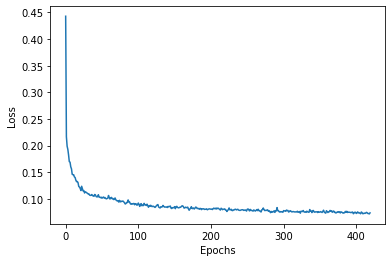

In [48]:
if indicators_model is None:
  indicators_model = Sequential()
  indicators_model.add(LSTM(units=42, activation='tanh', input_shape=(look_back, nr_of_features), return_sequences=True))
  indicators_model.add(Dropout(0.2))
  indicators_model.add(LSTM(units=42, return_sequences=True, activation="relu"))
  indicators_model.add(Dropout(0.2))
  indicators_model.add(LSTM(units=42, return_sequences=True, activation="relu"))
  indicators_model.add(Dropout(0.2))
  indicators_model.add(LSTM(units=42, activation="tanh"))
  indicators_model.add(Dropout(0.2))
  indicators_model.add(Dense(nr_of_features))

  indicators_model.compile(
      loss=MAE,
      optimizer=Adam(learning_rate=learning_rate),
      metrics=['mae','mse']
  )
    
  #model.summary()
  print('Model ' + indicators_model_file_path + ' compiled.')

  indicators_modelo = indicators_model.fit(indicators_train_generator, epochs=epochs, verbose=0 )
  
  indicators_model.save(indicators_model_file_path)
  print('Saved model ' + indicators_model_file_path)

  
  plt.plot(indicators_modelo.history['loss'])
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.show()

In [49]:
indicators_test_generator = TimeseriesGenerator(indicators_lstm_test_data_scaled, indicators_lstm_test_data_scaled,sampling_rate=1, length=look_back, batch_size=look_back)

print('Samples: %d' % len(indicators_test_generator))
# print each sample
if print_level >= TRACE:
  for i in range(2):
    x, y = indicators_test_generator[i]
    print('%s => %s' % (x, y))

Samples: 24


In [50]:
#Make prediction
indicators_prediction_scaled = indicators_model.predict(indicators_test_generator)

if print_level >= DEBUG:
  np.set_printoptions(formatter={'float': '{: 0.12f}'.format})
  print(indicators_prediction_scaled[:5])

indicators_prediction = indicators_scaler.inverse_transform(indicators_prediction_scaled)
if nr_of_features == 1:
   rsi_prediction = indicators_prediction.reshape((-1))
else:
  rsi_prediction = indicators_prediction[:,0].reshape((-1))
  stoch_slowD_prediction = indicators_prediction[:,1].reshape((-1))
  stoch_slowK_prediction = indicators_prediction[:,2].reshape((-1))

if print_level >= DEBUG:
  np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
  print('indicators_prediction shape:',indicators_prediction.shape)

  for x in range(look_back + 1):
    print('pred:',indicators_prediction[x], 'test:', indicators_lstm_test_data[x])


[[ 0.284163653851  0.120071649551  0.194200277328  0.371657729149]
 [ 0.263609528542  0.153165519238  0.202950239182  0.367528706789]
 [ 0.497111171484  0.234228700399  0.378269612789  0.399730235338]
 [ 0.784421086311  0.445017814636  0.704535901546  0.455112874508]
 [ 0.798258543015  0.742777764797  0.886002182961  0.517612695694]]
indicators_prediction shape: (70, 4)
pred: [ 30.17  16.25  21.52 -0.75] test: [ 8.78  13.76  12.40 -0.24]
pred: [ 28.20  19.20  22.34 -0.77] test: [ 7.36  12.98  13.55 -0.47]
pred: [ 50.56  26.43  38.83 -0.64] test: [ 7.15  15.67  21.05 -0.56]
pred: [ 78.06  45.23  69.53 -0.41] test: [ 3.53  17.16  16.88 -0.63]


In [53]:
def predict(num_prediction, model):
    prediction_list = indicators_lstm_test_data_scaled[-look_back:]
    #print('prediction_list',prediction_list)
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        #print(x)
        x = x.reshape((1, look_back, nr_of_features))
        out = model.predict(x)
        #print(x,out) 
        prediction_list = np.append(prediction_list, out, axis=0)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
    
def predict_dates(last_date,num_prediction):
    us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1,freq=us_bd).tolist()
    return prediction_dates

indicators_forecast_scaled = predict(num_prediction, indicators_model)
#print(forecast_scaled)
indicators_forecast_dates = predict_dates(indicators_df['Date'].values[-1],num_prediction)

indicators_forecast = indicators_scaler.inverse_transform(indicators_forecast_scaled.reshape((-1,nr_of_features)))
if nr_of_features == 1:
   rsi_forecast = indicators_forecast.reshape((-1))
else:
  rsi_forecast = indicators_forecast[:,0].reshape((-1))
  stoch_SlowD_forecast = indicators_forecast[:,1].reshape((-1))
  stoch_SlowK_forecast = indicators_forecast[:,2].reshape((-1))
  macd_hist_forecast = indicators_forecast[:,3].reshape((-1))

if print_level >= DEBUG:
  print('indicators_forecast:',indicators_forecast)
  print('rsi_forecast:',rsi_forecast)

indicators_forecast: [[ 21.82  14.61  23.59 -1.17]
 [ 45.93  24.14  34.83 -1.30]
 [ 57.52  34.54  49.40 -1.08]
 [ 67.45  51.45  68.68 -0.77]
 [ 72.60  68.46  78.61 -0.41]
 [ 75.55  78.15  82.37 -0.20]
 [ 77.99  82.41  82.35 -0.04]
 [ 79.63  83.17  81.72  0.07]
 [ 80.22  82.64  80.90  0.15]
 [ 80.32  81.85  80.30  0.21]
 [ 80.49  81.19  79.99  0.27]
 [ 80.71  80.65  79.79  0.34]
 [ 80.85  80.14  79.60  0.41]]
rsi_forecast: [ 21.82  45.93  57.52  67.45  72.60  75.55  77.99  79.63  80.22  80.32
  80.49  80.71  80.85]


In [61]:
#https://python.plainenglish.io/a-simple-guide-to-plotly-for-plotting-financial-chart-54986c996682
chart_days = len(indicators_df_test) * 2

#'Date','Close','Volume','High','Low','Open','Divident'
open_price =  str(stock_data[-1][5])
low_price =  str(stock_data[-1][3])
high_price =  str(stock_data[-1][4])
close_price =  str(stock_data[-1][1])
rsi_forecast_mean = np.round(np.mean(rsi_forecast))

tradingview_link = '<a href="https://in.tradingview.com/chart/66XmQfYy/?symbol=' + ticker +'">' + ticker +'</a>'
stock_title = tradingview_link + ' Date:' + last_date + ' Open:' + open_price + ' High:' + high_price + ' Low:' + low_price + ' Close:' + close_price
indicators_title = tradingview_link + ' RSI('+ str(look_back)+ ') Date:' + last_date + ' Close:' + indicators_df['RSI'].iloc[-1] + ' Forecast('+str(look_back)+'):' + str(rsi_forecast_mean)

fig = make_subplots(rows=4, cols=1, row_heights=[0.4, 0.2, 0.2, 0.2], subplot_titles=(stock_title, indicators_title))

go.Layout(
    title = ticker + ' Date:' + last_date + ' Open:' + open_price + ' High:' + high_price + ' Low:' + low_price + ' Close:' + close_price,
    xaxis = {'title' : "Dates"},
    yaxis = {'title' : "Close Price ($)"},
    height = 450
)

trace1 = go.Candlestick(
    x = stock_df.tail(chart_days)['Date'],
    open = stock_df.tail(chart_days)['Open'],
    high = stock_df.tail(chart_days)['High'],
    low = stock_df.tail(chart_days)['Low'],
    close = stock_df.tail(chart_days)['Close'],
    name = ticker + ' Price'
)

trace2 = go.Scatter(
    x = stock_df.tail(chart_days)['Date'],
    y = stock_df.tail(chart_days)['50MA'],
    mode='lines',
    name ='50MA'
)

trace3 = go.Scatter(
    x = stock_df.tail(chart_days)['Date'],
    y = stock_df.tail(chart_days)['100MA'],
    mode='lines',
    name ='100MA'
)

trace4 = go.Scatter(
    x = stock_df.tail(chart_days)['Date'],
    y = stock_df.tail(chart_days)['200MA'],
    mode='lines',
    name ='200MA'
)

fig.add_trace(trace1,row=1, col=1)
fig.add_trace(trace2,row=1, col=1)
fig.add_trace(trace3,row=1, col=1)
fig.add_trace(trace4,row=1, col=1)

trace_rsi_train = go.Scatter(
  x = indicators_df_train.tail(len(indicators_df_test))['Date'],
  y = indicators_df_train.tail(len(indicators_df_test))['RSI'],
  mode='lines',
  name ='RSI'
)

trace_rsi_test = go.Scatter(
  x = indicators_df_test['Date'],
  y = indicators_df_test['RSI'],
  mode='lines',
  name ='Test'
)

trace_rsi_prediction = go.Scatter(
    x = indicators_df_test['Date'],
    y = rsi_prediction,
    mode='markers+lines',
    name ='Prediction'
)

trace_rsi_forecast = go.Scatter(
    x = indicators_forecast_dates,
    y = rsi_forecast,
    mode='markers+lines',
    name ='Forecast'
)

fig.add_trace(trace_rsi_train,row=2, col=1)
fig.add_trace(trace_rsi_test,row=2, col=1)
fig.add_trace(trace_rsi_prediction,row=2, col=1)
fig.add_trace(trace_rsi_forecast,row=2, col=1)

fig.add_trace(go.Scatter(
        x = [indicators_df_train.tail(len(indicators_df_test))['Date'].min(), np.max(indicators_forecast_dates)],
        y = [70, 70],
        mode = "lines",
        line = dict(shape = 'linear', color = 'rgb(100, 10, 100)', dash = 'dash')
    ),row=2, col=1)

fig.add_trace(go.Scatter(
        x = [indicators_df_train.tail(len(indicators_df_test))['Date'].min(), np.max(indicators_forecast_dates)],
        y = [50, 50],
        mode = "lines",
        line = dict(shape = 'linear', color = 'rgb(10, 12, 240)', dash = 'dash')
    ),row=2, col=1)

fig.add_trace(go.Scatter(
        x = [indicators_df_train.tail(len(indicators_df_test))['Date'].min(), np.max(indicators_forecast_dates)],
        y = [30, 30],
        mode = "lines",
        line = dict(shape = 'linear', color = 'rgb(10, 120, 24)', dash = 'dash')
    ),row=2, col=1)


trace_stoch_SlowK_train = go.Scatter(
  x = indicators_df_train.tail(len(indicators_df_test))['Date'],
  y = indicators_df_train.tail(len(indicators_df_test))['SlowK'],
  mode='lines',
  name ='Train Stoch SlowK'
)

trace_stoch_SlowD_train = go.Scatter(
  x = indicators_df_train.tail(len(indicators_df_test))['Date'],
  y = indicators_df_train.tail(len(indicators_df_test))['SlowD'],
  mode='lines',
  name ='Train Stoch SlowD'
)

trace_stoch_SlowD_test = go.Scatter(
  x = indicators_df_test['Date'],
  y = indicators_df_test['SlowD'],
  mode='lines',
  name ='Test Stoch SlowD'
)

trace_stoch_SlowK_test = go.Scatter(
  x = indicators_df_test['Date'],
  y = indicators_df_test['SlowK'],
  mode='lines',
  name ='Test Stoch SlowK'
)

trace_stoch_SlowD_prediction = go.Scatter(
    x = indicators_df_test['Date'],
    y = stoch_slowD_prediction,
    mode='markers+lines',
    name ='Prediction Stoch SlowD'
)

trace_stoch_SlowK_prediction = go.Scatter(
    x = indicators_df_test['Date'],
    y = stoch_slowK_prediction,
    mode='markers+lines',
    name ='Prediction Stoch SlowK'
)

trace_stoch_SlowD_forecast = go.Scatter(
    x = indicators_forecast_dates,
    y = stoch_SlowD_forecast,
    mode='markers+lines',
    name ='Forecast Stoch SlowD'
)

trace_stoch_SlowK_forecast = go.Scatter(
    x = indicators_forecast_dates,
    y = stoch_SlowK_forecast,
    mode='markers+lines',
    name ='Forecast Stoch SlowK'
)

fig.add_trace(trace_stoch_SlowK_train, row=3,col=1 )
fig.add_trace(trace_stoch_SlowD_train, row=3,col=1 )
fig.add_trace(trace_stoch_SlowD_test, row=3,col=1 )
fig.add_trace(trace_stoch_SlowK_test, row=3,col=1 )
fig.add_trace(trace_stoch_SlowD_prediction, row=3,col=1 )
fig.add_trace(trace_stoch_SlowK_prediction, row=3,col=1 )
fig.add_trace(trace_stoch_SlowD_forecast, row=3,col=1 )
fig.add_trace(trace_stoch_SlowK_forecast, row=3,col=1 )

fig.add_trace(go.Scatter(
        x = [indicators_df_train.tail(len(indicators_df_test))['Date'].min(), np.max(indicators_forecast_dates)],
        y = [70, 70],
        mode = "lines",
        line = dict(shape = 'linear', color = 'rgb(100, 10, 100)', dash = 'dash')
    ),row=3, col=1)

fig.add_trace(go.Scatter(
        x = [indicators_df_train.tail(len(indicators_df_test))['Date'].min(), np.max(indicators_forecast_dates)],
        y = [50, 50],
        mode = "lines",
        line = dict(shape = 'linear', color = 'rgb(10, 12, 240)', dash = 'dash')
    ),row=3, col=1)

fig.add_trace(go.Scatter(
        x = [indicators_df_train.tail(len(indicators_df_test))['Date'].min(), np.max(indicators_forecast_dates)],
        y = [30, 30],
        mode = "lines",
        line = dict(shape = 'linear', color = 'rgb(10, 120, 24)', dash = 'dash')
    ),row=3, col=1)

#colors = ['green' if row['Open'] - row['Close'] >= 0 
#          else 'red' for index, row in trace_macd_train.iterrows()]
trace_macd_train = go.Bar(
  x = indicators_df_train.tail(len(indicators_df_test))['Date'],
  y = indicators_df_train.tail(len(indicators_df_test))['MACD_Hist']
)

trace_macd_test = go.Bar(
  x = indicators_df_test['Date'],
  y = indicators_df_test['MACD_Hist']
)

trace_macd_hist_forecast = go.Bar(
    x = indicators_forecast_dates,
    y = macd_hist_forecast,
    marker_color=['black']
)


fig.add_trace(trace_macd_train, row=4,col=1 )
fig.add_trace(trace_macd_test, row=4,col=1 )
fig.add_trace(trace_macd_hist_forecast, row=4,col=1 )

fig.update_yaxes(showspikes=True, spikemode='across', spikesnap='cursor',spikedash='dash')
fig.update_xaxes(showspikes=True, spikemode='across', spikesnap='cursor', spikedash='dash')
fig.update_layout(xaxis_rangeslider_visible=False,height=650)
fig.update_layout(margin=go.layout.Margin(
        l=20, #left margin
        r=20, #right margin
        b=20, #bottom margin
        t=20  #top margin
    ))
fig.show()
folder='/content/drive/MyDrive/models/charts/'+ last_date
Path(folder).mkdir(parents=True, exist_ok=True)
print('chart folder:', folder)
fig.write_html(folder + '/' + ticker + '_' + str(look_back) + '_' + str(nr_of_features) + '_09_inidicators_forecast.html')

chart folder: /content/drive/MyDrive/models/charts/2021-11-26
